# Racing line calculation and visualisation

The approach is to smooth central line of a given track. This is achieved by minimising the distance between each pair
 of two closes waypoints. Selected closes waypoints are not always the nearest waypoints, such as between a pair of
 selected waypoints, there might be others waypoints located closer. However, these are still close enough to be used.
 This is controlled by skipp_step parameter, which allows acceleration of the algorithm. The optimisation algorithm
 takes into account track's inner and outer borders to ensure that new calculated waypoints do not touch the borders or
 go beyond the borders or located too close to the borders. This is controlled by  max_offset parameter.

This algorithm does not search for an optimal arc of corners to race at the maximum possible speed for a given steering.

In [1]:
import glob
import math
import os.path
import importlib.util
import numpy as np
import matplotlib.pyplot as plt

def load_track_definition(track_name):
    spec = importlib.util.spec_from_file_location(track_name, "../tracks/%s.py" % track_name)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module.track_width, np.asarray(module.track_original)

def calc_track_borders(track_width, center_line):
    delta_x = (np.roll(center_line[:,0], 1) - np.roll(center_line[:,0], -1))
    delta_y = (np.roll(center_line[:,1], 1) - np.roll(center_line[:,1], -1))
    delta_xy = np.vstack((delta_x, delta_y)).T
    l2_norm = np.array([math.hypot(dx, dy) for [dx, dy] in delta_xy])
    sinAlpa = delta_x / l2_norm
    cosAlpa = delta_y / l2_norm

    half_track_width = track_width * 0.5
    inner_border_x = center_line[:,0] + cosAlpa * half_track_width
    inner_border_y = center_line[:,1] - sinAlpa * half_track_width

    outer_border_x = center_line[:,0] - cosAlpa * half_track_width
    outer_border_y = center_line[:,1] + sinAlpa * half_track_width

    inner_border = np.vstack((inner_border_x, inner_border_y)).T
    outer_border = np.vstack((outer_border_x, outer_border_y)).T
    return inner_border, outer_border

track_files = glob.glob("../tracks/*.npy")
track_names = list(map(lambda x: os.path.basename(x).split(".npy")[0], track_files))
print("Available tracks:", track_names)

Available tracks: ['Baadal_Track', 'Expedition_Super_Loop', 'Playa_Raceway']


In [2]:
TRACK_NAME = "Baadal_Track"
print("Track: ", TRACK_NAME)

Track:  Baadal_Track


##### Use the following steps to create new .npy file for a track, if not available above.
new_track_width, new_center_line = load_track_definition(TRACK_NAME)
new_inner_border, new_outer_border = calc_track_borders(new_track_width, new_center_line)
NEW_WAYPOINTS = np.concatenate((new_center_line, new_inner_border, new_outer_border), axis=1)
with open("../tracks/%s.npy" % TRACK_NAME, "wb") as f:
    np.save(f, np.asarray(NEW_WAYPOINTS))

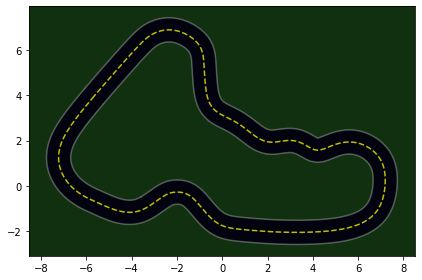

In [4]:
# Load track coordinates
waypoints = np.load("../tracks/%s.npy" % TRACK_NAME)
center_line = waypoints[:,0:2]
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]

def plot_track(smooth_line, inner_border, outer_border, center_line = None):
    fig, ax = plt.subplots()
    ax.set_facecolor("#103010")
    if center_line is not None:
            ax.plot(center_line[:,0], center_line[:,1], 'y--', alpha=0.3, label = 'center_line')
    ax.plot(smooth_line[:,0], smooth_line[:,1], 'y--', label = 'smooth_line')
    ax.plot(inner_border[:,0], inner_border[:,1], 'w-', alpha=0.3, label = 'inner_border')
    ax.plot(outer_border[:,0], outer_border[:,1], 'w-', alpha=0.3, label = 'outer_border')
    ax.fill_between(outer_border[:,0], outer_border[:,1], outer_border[:+1,1], facecolor="#03030f")
    ax.fill_between(inner_border[:,0], inner_border[:,1], inner_border[:+1,1], facecolor="#103010")
    fig.tight_layout()
    plt.axis('scaled')
    return plt


def calc_distance(prev_point, next_point):
    delta_x = next_point[0] - prev_point[0]
    delta_y = next_point[1] - prev_point[1]
    return math.hypot(delta_x, delta_y)


def smooth_central_line(center_line, max_offset, pp, p, c, n, nn, iterations=72, skip_step=1):
    smoothed_line = center_line
    for i in range(0, iterations):
        smoothed_line = smooth_central_line_internal(center_line, max_offset, smoothed_line, pp, p, c, n, nn, skip_step)
    return smoothed_line


def smooth_central_line_internal(center_line, max_offset, smoothed_line, pp, p, c, n, nn, skip_step):
    length = len(center_line)
    new_line = [[0.0 for _ in range(2)] for _ in range(length)]
    for i in range(0, length):
        wpp = smoothed_line[(i - 2 * skip_step + length) % length]
        wp = smoothed_line[(i - skip_step + length) % length]
        wc = smoothed_line[i]
        wn = smoothed_line[(i + skip_step) % length]
        wnn = smoothed_line[(i + 2 * skip_step) % length]
        new_line[i][0] = pp * wpp[0] + p * wp[0] + c * wc[0] + n * wn[0] + nn * wnn[0]
        new_line[i][1] = pp * wpp[1] + p * wp[1] + c * wc[1] + n * wn[1] + nn * wnn[1]
        while calc_distance(new_line[i], center_line[i]) >= max_offset:
            new_line[i][0] = (0.98 * new_line[i][0]) + (0.02 * center_line[i][0])
            new_line[i][1] = (0.98 * new_line[i][1]) + (0.02 * center_line[i][1])
    return new_line


def show_smooth_line(smooth_cline, center_line, inner_border, outer_border):
    # These should be the same
    np_smooth_cline = np.asarray(smooth_cline)
    length_of_center_line = 0.0
    for i in range(1, len(center_line)):
        length_of_center_line += calc_distance(center_line[i - 1], center_line[i])
    length_of_smooth_cline = 0.0
    for i in range(1, len(smooth_cline)):
        length_of_smooth_cline += calc_distance(smooth_cline[i - 1], smooth_cline[i])
    print("Original line length: %0.2f" % length_of_center_line)
    print("New race line length: %0.2f" % length_of_smooth_cline)
    return plot_track(np_smooth_cline, inner_border, outer_border, center_line)


track = plot_track(center_line, inner_border, outer_border)
track.savefig("../tracks/%s.png" % TRACK_NAME, bbox_inches='tight', dpi=300)
track.show()

Original line length: 39.07
New race line length: 35.63


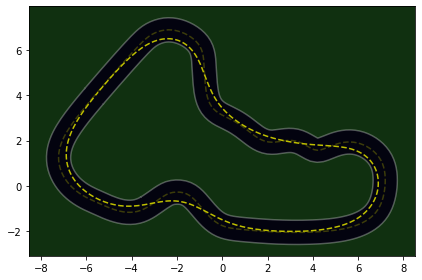

In [9]:
track_width = 1.07
follow_the_central_line_ratio = 0.02
max_offset = track_width * ((1.0 - follow_the_central_line_ratio) / 2.0)

smooth_cline1 = smooth_central_line(center_line, max_offset, 0.10, 0.05, 0.70, 0.05, 0.10)
track = show_smooth_line(smooth_cline1, center_line, inner_border, outer_border)
track.savefig("../tracks/%s_v1.png" % TRACK_NAME, bbox_inches='tight', dpi=300)
track.show()

Original line length: 39.07
New race line length: 33.90


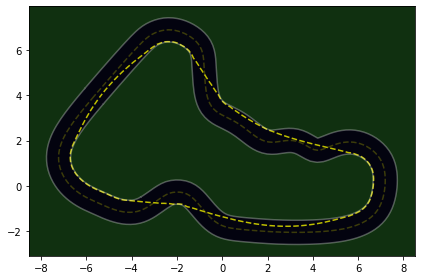

In [7]:
smooth_cline2 = smooth_central_line(center_line, max_offset, 0.10, 0.05, 0.70, 0.05, 0.10, skip_step=2)
track = show_smooth_line(smooth_cline2, center_line, inner_border, outer_border)
track.savefig("../tracks/%s_v2.png" % TRACK_NAME, bbox_inches='tight', dpi=300)
track.show()

Original line length: 39.07
New race line length: 33.77


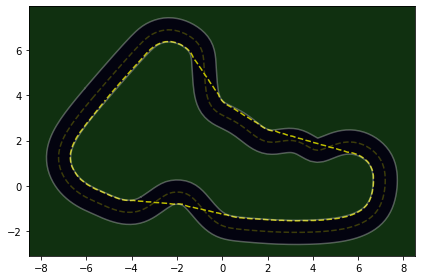

In [8]:
smooth_cline3 = smooth_central_line(center_line, max_offset, 0.10, 0.15, 0.50, 0.15, 0.10, skip_step=3)
track = show_smooth_line(smooth_cline3, center_line, inner_border, outer_border)
track.savefig("../tracks/%s_v3.png" % TRACK_NAME, bbox_inches='tight', dpi=300)
track.show()

In [33]:
smooth_cline3

[[6.509022100236237, -1.8847108975009867],
 [6.528318953922864, -1.6577735777817182],
 [6.543420066271024, -1.4315441058505558],
 [6.557076088007781, -1.2059666644499327],
 [6.575029568851624, -0.9782546536764484],
 [6.589821018814872, -0.7521332219003422],
 [6.603509743017192, -0.526359369452213],
 [6.619719463927407, -0.29822714633735636],
 [6.6355718658439145, -0.07247216690557662],
 [6.650213572473403, 0.15363294775819045],
 [6.6667154289211155, 0.3823817182509548],
 [6.682814005122206, 0.6077733005174943],
 [6.694109634526631, 0.834389792661528],
 [6.704036581503317, 1.0630953812101396],
 [6.717061750711722, 1.287248923751242],
 [6.741811165757569, 1.514740356485781],
 [6.76507044295262, 1.744781272757293],
 [6.77823765840581, 1.969069579706778],
 [6.778779627367243, 2.1994395734373255],
 [6.74410486499649, 2.424487506925819],
 [6.703949884759018, 2.6410498152330346],
 [6.632405707424845, 2.8525098971971046],
 [6.51112069209184, 3.046142707726266],
 [6.367267927997826, 3.214741553